In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import absolute_import, division, print_function

%matplotlib inline
%connect_info

{
  "stdin_port": 53462, 
  "ip": "127.0.0.1", 
  "control_port": 53463, 
  "hb_port": 53464, 
  "signature_scheme": "hmac-sha256", 
  "key": "e3117172-eeb0-4d94-a88a-b34b5cd1ac50", 
  "kernel_name": "", 
  "shell_port": 53460, 
  "transport": "tcp", 
  "iopub_port": 53461
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /Users/hkwik/Library/Jupyter/runtime/kernel-09d665b3-5ee3-4d62-886d-dc325e82515b.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [2]:
date_chunks = pd.read_csv("data/train_date.csv", index_col=0, chunksize=100000, dtype=np.float32)
num_chunks = pd.read_csv("data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=100000, dtype=np.float32)

In [3]:
X = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y = pd.read_csv("data/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[X.index].values.ravel()


In [18]:
#fail_time_score = pd.read_csv("fail_date_score.csv", index_col=0, dtype=np.float32).loc[X.index]

# X.concat(fail_time_score, axis=1)
#X['fail_time_score'] = pd.Series(fail_time_score.name.values, index = fail_time_score.index.isin(X.index))


# X = X.values

In [25]:
#

In [4]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[  34   76  831  939  946 1018 1019 1029 1034 1038 1050 1056 1157 1163 1191
 1196 1197 1201 1207 1222 1226 1232 1250 1270 1272 1278 1290 1308 1316 1322
 1497 1501 1512 1520 1523 1532 1549 1550 1589 1801 1842 1843 1847 1881 1882
 1884 1885 1887 1888 1891 1892 1913 1928 1937 1938 1949 1961 1974 1982 1983
 1984 1985 1987 1988 1993 1997 2006 2007 2010 2028]


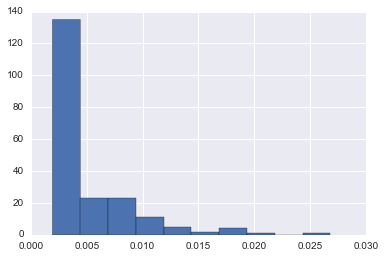

In [5]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [ ]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values,
    pd.read_csv("fail_date_score.csv", index_col=0, header=None, dtype=np.float32).values
], axis=1)

y = pd.read_csv("data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [ ]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

1.0


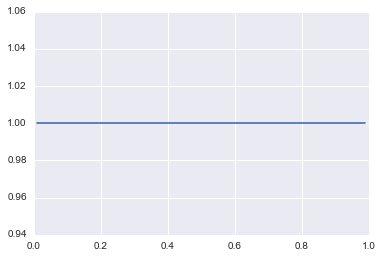

In [33]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [34]:
# load test data
X = np.concatenate([
    pd.read_csv("data/test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("data/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values
], axis=1)

ValueError: Usecols do not match names.

In [ ]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [ ]:
# and submit
sub = pd.read_csv("data/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")